# Table of Contents
* [Set up environment](#env)
* [Read in Data](#load)
    * [Map IP Address to Country](#ip)
    * [Feature Engineering](#fea)
    * [Variable Sanity Check](#san)
* [Fraudulent Activity Prediction](#pres)
    * [Grid Search Hyper-parameters](#hyper)
    * [Optimal Random Forest Model](#opt) 
    * [Implications of False Positives vs False Negatives](#fp)
    * [Images of High Fraudulent Risk Users](#im)   
* [Model Usage and Recommendation](#re)


Goal of this data challenge: to predict the probability that the first transaction of a new user is fraudulent.

Several questions need to be addressed:
* For each user, determine her country based on the numeric IP address.
* Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs false negatives would impact the model.
* Interpret the model: What kinds of users are more likely to be classified as at risk? What are their characteristics?
* From a product perspective, how would you use the model to tell if an activity is fraudulent or not? That is, what kind of different user experiences would you build based on the model output?

# Set up Environment
<a id="env"></a> 

In [214]:
# import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import warnings
warnings.simplefilter('default')
from scipy import stats

# Read in Data
<a id="load"></a> 

In [215]:
# read in fraud_table
fraud_df = pd.read_csv("./Fraud/Fraud_Data.csv")
fraud_df.shape

(151112, 11)

In [243]:
fraud_df.user_id.nunique()

151112

In [216]:
# read in ip_table
ip_df = pd.read_csv("./Fraud/IpAddress_to_Country.csv")
ip_df.shape

(138846, 3)

In [217]:
fraud_df.columns

Index([u'user_id', u'signup_time', u'purchase_time', u'purchase_value',
       u'device_id', u'source', u'browser', u'sex', u'age', u'ip_address',
       u'class'],
      dtype='object')

In [218]:
ip_df.columns

Index([u'lower_bound_ip_address', u'upper_bound_ip_address', u'country'], dtype='object')

In [219]:
pd.isnull(fraud_df).sum()

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

In [220]:
pd.isnull(ip_df).sum()

lower_bound_ip_address    0
upper_bound_ip_address    0
country                   0
dtype: int64

In [221]:
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
user_id           151112 non-null int64
signup_time       151112 non-null object
purchase_time     151112 non-null object
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
ip_address        151112 non-null float64
class             151112 non-null int64
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [222]:
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])

In [223]:
ip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
lower_bound_ip_address    138846 non-null float64
upper_bound_ip_address    138846 non-null int64
country                   138846 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [224]:
ip_df['upper_bound_ip_address'] = ip_df.upper_bound_ip_address.astype('float64')

## Map IP Address to Country
<a id="ip"></a> 

* Three different method can be used to do the mapping:
SQL or line by line iteration or binary search

Use line by line iteration: very time consuming, time complexity is O(m*n);
To run SQL on python, we need to connect to a database with sqlite3

In [225]:
countries = []
for i in range(len(fraud_df)):
    ip_address = fraud_df.loc[i, 'ip_address']
    tmp = ip_df[(ip_df['lower_bound_ip_address'] <= ip_address) &
                          (ip_df['upper_bound_ip_address'] >= ip_address)]
    if len(tmp) == 1:
        countries.append(tmp['country'].values[0])
    else:
        countries.append('unknown')
        
fraud_df['country'] = countries
fraud_df.country.value_counts()

United States                      58049
unknown                            21966
China                              12038
Japan                               7306
United Kingdom                      4490
Korea Republic of                   4162
Germany                             3646
France                              3161
Canada                              2975
Brazil                              2961
Italy                               1944
Australia                           1844
Netherlands                         1680
Russian Federation                  1616
India                               1310
Taiwan; Republic of China (ROC)     1237
Mexico                              1121
Sweden                              1090
Spain                               1027
South Africa                         838
Switzerland                          785
Poland                               729
Argentina                            661
Indonesia                            649
Norway          

Use binary search to reduce the time complexity O(mlogn)

In [198]:
# def iplookup(ip_df, fraud_df):
#     fraud_df['country'] = ''
#     ip_df = ip_df.sort_values(by='lower_bound_ip_address', ascending = True)
#     for i in range(fraud_df.shape[0]):
#         if fraud_df.loc[i,'ip_address'] < ip_df.loc[0,'lower_bound_ip_address'] or fraud_df.loc[i,'ip_address'] > ip_df.loc[ip_df.shape[0]-1,'upper_bound_ip_address']:
#             continue
#         else: 
#             start = 0
#             end = ip_df.shape[0]-1
#             while start + 1 < end:
#                 mid = (end - start)/2 + start
#                 if fraud_df.loc[i,'ip_address'] >= ip_df.loc[mid,'lower_bound_ip_address'] and fraud_df.loc[i,'ip_address'] <= ip_df.loc[mid,'upper_bound_ip_address']:
#                     fraud_df.loc[i,'country'] = ip_df.loc[mid,'country']
#                     break
#                 elif fraud_df.loc[i,'ip_address'] > ip_df.loc[mid,'upper_bound_ip_address']:
#                     start = mid
#                 else:
#                     end = mid
#             if fraud_df.loc[i,'ip_address'] >= ip_df.loc[end,'lower_bound_ip_address']:
#                 fraud_df.loc[i,'country'] = ip_df.loc[end,'country']
#             else:
#                 fraud_df.loc[i,'country'] = ip_df.loc[start,'country']
#     return fraud_df

In [199]:
# fraud_df = iplookup(ip_df, fraud_df)

In [212]:
# fraud_df.country[fraud_df.country == ''] = 'unknown'

/Applications/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Feature Engineering
<a id="fea"></a> 

* create variables 'time_diff' = 'purchase_time' - 'signup_time'; it's suspicious that user make purchases right after signing-up.
* create variables 'signup_week', 'signup_day', 'purchase_week', 'purchase_day'; these variables will help to capture the seasonality trend.
* create variable 'no_ip_common', which indicates how many ip address are in common; if couple users share the same ip_address, then those users are suspecious.
* create variable 'no_device_common', which indicates how many device are used in common by different users; if couple users share the same device_id, then those users are suspecious.

In [231]:
# get the signup_week, signup_day, purchase_week, purchase_day
fraud_df['signup_week'] = fraud_df['signup_time'].dt.week
fraud_df['signup_day'] = fraud_df['signup_time'].dt.weekday_name
fraud_df['purchase_week'] = fraud_df['purchase_time'].dt.week
fraud_df['purchase_day'] = fraud_df['purchase_time'].dt.weekday_name

In [240]:
# create time_diff in seconds
fraud_df['time_diff'] = (fraud_df.purchase_time-fraud_df.signup_time).astype('timedelta64[s]')

In [261]:
n_ip_shared = fraud_df.ip_address.value_counts()
fraud_df['no_ip_common'] = fraud_df.ip_address.map(n_ip_shared)

In [263]:
n_dev_shared = fraud_df.device_id.value_counts()
fraud_df['no_device_common'] = fraud_df.device_id.map(n_dev_shared)

In [268]:
fraud_df = fraud_df.drop(columns = ['user_id','signup_time','purchase_time','device_id','ip_address'])

## Variable Sanity Check
<a id="san"></a> 

Check the numeric variables:

In [290]:
fraud_df.describe()

,purchase_value,age,class,signup_week,purchase_week,time_diff,no_ip_common,no_device_common
count,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000,151112.000000
mean,36.935372,33.140704,0.093646,16.501740,24.658571,4.932029e+06,1.602719,1.684367
std,18.322762,8.617733,0.291336,9.814287,11.651557,3.126263e+06,2.596240,2.616954
min,9.000000,18.000000,0.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000
25%,22.000000,27.000000,0.000000,8.000000,16.000000,2.186754e+06,1.000000,1.000000
50%,35.000000,33.000000,0.000000,16.000000,25.000000,4.926346e+06,1.000000,1.000000
75%,49.000000,39.000000,0.000000,25.000000,34.000000,7.644524e+06,1.000000,1.000000
max,154.000000,76.000000,1.000000,34.000000,51.000000,1.036797e+07,20.000000,20.000000


Check the categorical variables:

In [273]:
fraud_df.source.value_counts()

SEO       60615
Ads       59881
Direct    30616
Name: source, dtype: int64

In [275]:
fraud_df.browser.value_counts()

Chrome     61432
IE         36727
Safari     24667
FireFox    24610
Opera       3676
Name: browser, dtype: int64

In [277]:
fraud_df.sex.value_counts()

M    88293
F    62819
Name: sex, dtype: int64

Imbalanced Classes: will need oversampling of the minority class.

In [288]:
fraud_df['class'].value_counts()

0    136961
1     14151
Name: class, dtype: int64

# Fraudulent Activity Prediction
<a id="pred"></a> 

In [393]:
# Split the data into training and testing data
# from sklearn.model_selection import train_test_split
# random_state = 42
# X_train, X_test, y_train, y_test = train_test_split(fraud_df.loc[:,fraud_df.columns!='class'],
#                                                     fraud_df['class'], test_size=0.33, random_state=42)

https://github.com/h2oai/h2o-tutorials/blob/master/SUMMARY.md

In [394]:
import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,14 hours 18 mins
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.0.2
H2O cluster version age:,18 days
H2O cluster name:,H2O_from_python_dannichen_ptrp6z
H2O cluster total nodes:,1
H2O cluster free memory:,1.825 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


In [395]:
# Transform data to H2O Frame, and make sure the target variable is categorical
h2o_df = h2o.H2OFrame(fraud_df)
h2o_df['class'] = h2o_df['class'].asfactor()
h2o_df.describe()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Rows:151112
Cols:14




,purchase_value,source,browser,sex,age,class,country,signup_week,signup_day,purchase_week,purchase_day,time_diff,no_ip_common,no_device_common
type,int,enum,enum,enum,int,enum,enum,int,enum,int,enum,int,int,int
mins,9.0,,,,18.0,,,1.0,,1.0,,1.0,1.0,1.0
mean,36.935372439,,,,33.1407035841,,,16.5017404309,,24.6585711261,,4932029.24862,1.60271851342,1.68436656255
maxs,154.0,,,,76.0,,,34.0,,51.0,,10367972.0,20.0,20.0
sigma,18.3227621487,,,,8.61773349096,,,9.8142874618,,11.6515567827,,3126263.11844,2.59623952738,2.6169536028
zeros,0,,,,0,,,0,,0,,0,0,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,34.0,SEO,Chrome,M,39.0,0,Japan,9.0,Tuesday,16.0,Saturday,4506682.0,1.0,1.0
1,16.0,Ads,Chrome,F,53.0,0,United States,23.0,Sunday,24.0,Monday,17944.0,1.0,1.0
2,15.0,SEO,Opera,M,53.0,1,United States,1.0,Thursday,1.0,Thursday,1.0,12.0,12.0


In [396]:
# Split data into training and testing
train,test,valid = h2o_df.split_frame(ratios=[0.7,0.15])
feature = h2o_df.columns
target = "class"
feature.remove(target)

## Grid Search Hyper-parameters
<a id="hyper"></a> 

In [398]:
from h2o.grid.grid_search import H2OGridSearch

# DRF hyperparameters
drf_params1 = {'ntrees': [100, 150, 200],
                'max_depth': [4, 7, 10],
                'sample_rate': [0.6, 0.7, 0.8],
                'col_sample_rate_per_tree': [0.6, 0.8, 1.0]}

# Train and validate a cartesian grid of DRFs
drf_grid1 = H2OGridSearch(model=H2ORandomForestEstimator,
                          grid_id='drf_grid1',
                          hyper_params=drf_params1)

drf_grid1.train(x=feature, y=target,
                training_frame=train,
                validation_frame=valid,
                balance_classes=True,
                stopping_rounds=5, 
                mtries=-1, 
                stopping_metric='auc', 
                score_each_iteration=True, 
                seed=42)

# Get the grid results, sorted by validation AUC
drf_gridperf1 = drf_grid1.get_grid(sort_by='auc', decreasing=True)
drf_gridperf1

# Grab the top DRF model, chosen by validation AUC
best_drf1 = drf_gridperf1.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_drf_perf1 = best_drf1.model_performance(test)

best_drf_perf1.auc()  # 0.8689232693256981

drf Grid Build progress: |████████████████████████████████████████████████| 100%


0.8689232693256981

In [401]:
drf_gridperf1

       col_sample_rate_per_tree max_depth ntrees sample_rate  \
0                           1.0         4    200         0.5   
1                           1.0         4    150         0.5   
2                           1.0         4    250         0.5   
3                           1.0         4    150         0.4   
4                           1.0         4    250         0.4   
5                           1.0         4    150         0.4   
6                           1.0         4    200         0.4   
7                           1.0         3    250         0.5   
8                           1.0         3    150         0.5   
9                           1.0         3    200         0.5   
10                          1.0         4    100         0.6   
11                          1.0         4     50         0.6   
12                          1.0         4    150         0.6   
13                          1.0         4    250         0.6   
14                          1.0         

Fine-tunning hyperparameters

In [400]:
# DRF hyperparameters
drf_params1 = {'ntrees': [150, 200, 250],
                'max_depth': [3, 4, 5],
                'sample_rate': [0.4, 0.5, 0.6],
                'col_sample_rate_per_tree': [1.0, 0.9]}

# Train and validate a cartesian grid of DRFs
drf_grid1 = H2OGridSearch(model=H2ORandomForestEstimator,
                          grid_id='drf_grid1',
                          hyper_params=drf_params1)

drf_grid1.train(x=feature, y=target,
                training_frame=train,
                validation_frame=valid,
                balance_classes=True,
                stopping_rounds=5, 
                mtries=-1, 
                stopping_metric='auc', 
                score_each_iteration=True, 
                seed=42)

# Get the grid results, sorted by validation AUC
drf_gridperf1 = drf_grid1.get_grid(sort_by='auc', decreasing=True)
drf_gridperf1

# Grab the top DRF model, chosen by validation AUC
best_drf1 = drf_gridperf1.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_drf_perf1 = best_drf1.model_performance(test)

best_drf_perf1.auc()  # 0.8689232693256981

drf Grid Build progress: |████████████████████████████████████████████████| 100%


0.8689232693256981

## Optimal Random Forest Model
<a id="opt"></a> 

In [403]:
# Build Random Forest Model
# Best hyperparameter combination
#'ntrees': 200, 'max_depth': 4, 'sample_rate': 0.5, 'col_sample_rate_per_tree': 1.0
model = H2ORandomForestEstimator(balance_classes=True, 
                                 ntrees=200, 
                                 max_depth=4, 
                                 sample_rate=0.5,
                                 col_sample_rate_per_tree=1.0,
                                 mtries=-1, 
                                 stopping_rounds=5, 
                                 stopping_metric='auc', 
                                 score_each_iteration=True, 
                                 seed=42)

model.train(x=feature, y=target, training_frame=train, validation_frame=test)
model.score_history()

drf Model Build progress: |███████████████████████████████████████████████| 100%


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2018-12-10 09:26:02,0.063 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2018-12-10 09:26:02,0.331 sec,1.0,0.459971,0.735167,0.775024,0.315572,2.000063,0.231311,0.199842,0.171414,0.774285,0.142666,10.93906,0.041672
2,,2018-12-10 09:26:02,0.448 sec,2.0,0.460106,0.735705,0.776137,0.663650,2.000063,0.231580,0.199657,0.171288,0.775601,0.189036,10.93906,0.041672
3,,2018-12-10 09:26:03,0.573 sec,3.0,0.454194,0.706696,0.833144,0.651257,2.000063,0.199132,0.197210,0.162268,0.851951,0.231886,10.93906,0.041716
4,,2018-12-10 09:26:03,0.680 sec,4.0,0.453620,0.703235,0.837962,0.777515,2.000063,0.193374,0.196792,0.161252,0.850173,0.230380,10.93906,0.041716
5,,2018-12-10 09:26:03,0.874 sec,5.0,0.453345,0.700886,0.840917,0.766071,2.000063,0.190220,0.196759,0.161193,0.853542,0.232568,10.93906,0.041628
6,,2018-12-10 09:26:03,1.095 sec,6.0,0.451231,0.691245,0.846293,0.763359,2.000063,0.182404,0.195954,0.159001,0.855109,0.234196,10.93906,0.041672
7,,2018-12-10 09:26:03,1.285 sec,7.0,0.449889,0.685638,0.848186,0.829034,2.000063,0.179044,0.195452,0.157767,0.855756,0.234116,10.93906,0.041672
8,,2018-12-10 09:26:04,1.696 sec,8.0,0.448596,0.680990,0.849015,0.860482,2.000063,0.177620,0.195039,0.156866,0.855881,0.233431,10.93906,0.041672
9,,2018-12-10 09:26:04,1.854 sec,9.0,0.450196,0.685019,0.849774,0.859276,2.000063,0.177173,0.195386,0.157596,0.857815,0.235019,10.93906,0.041848


## Implications of False Positives vs False Negatives
<a id="fp"></a> 

In [405]:
from sklearn.metrics import auc, roc_curve, classification_report
# Make predictions 
train_true = train.as_data_frame()['class'].values
test_true = test.as_data_frame()['class'].values
train_pred = model.predict(train).as_data_frame()['p1'].values
test_pred = model.predict(test).as_data_frame()['p1'].values

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [407]:
# Classification report
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.5).astype(int)))

             precision    recall  f1-score   support

          0       0.96      1.00      0.98     20713
          1       1.00      0.54      0.70      2084

avg / total       0.96      0.96      0.95     22797



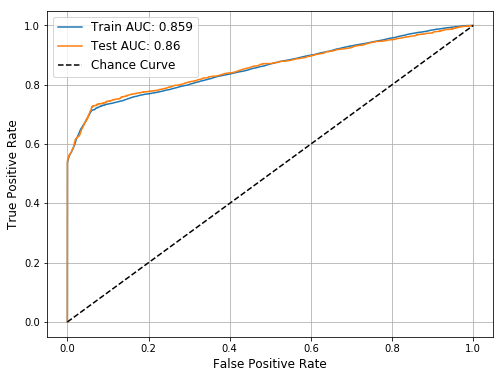

In [408]:
train_fpr = np.insert(train_fpr, 0, 0)
train_tpr = np.insert(train_tpr, 0, 0)
test_fpr = np.insert(test_fpr, 0, 0)
test_tpr = np.insert(test_tpr, 0, 0)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.plot(train_fpr, train_fpr, 'k--', label='Chance Curve')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.grid(True)
ax.legend(fontsize=12)
plt.show()

Cost of False Positive: Some non-fraudulent users are mistakenly classified as fraudulent users and the transaction of purchase get blocked. It will deteriorate the user experience, and further reduce the revenue.

Cost of False Negtive: Fraudulent users didn't captured and blocked by the website. In that, the website ship out the merchandise but didn't get the payment back, so the company lose big chunk of money directly.

From the ROC curve, by decreasing the cut-off p, the true positive rate increase from ~0.5 to 1.0, and at the same time, the false positive rate increase from 0 to 1.0, and the false negtive rate decrease from ~ 0.5 to 0. When the cut-off p of the model is too high, a lot of fradulent users are not detected and company directly lose money from the fraud activities. When the cut-off p of the model is too low, a lot of good users are misclassified as fraud users and the whole website is not doing business any more.

A good strategy is to test the cut-off p against the website revenue, and set the cut-off to balance both False Positive and False Negtive.

## Images of High Fraudulent Risk Users
<a id="im"></a> 

Based on the following Variable Importance Ranking and the Partial Dependence Plot, variables "purchase week", "number of users share the same device", "the time difference between sign up and purchase" and "number of users share the same ip address" are the top four features to capture the high fraudulent risk users in the model.

We can tell that the users with the following characteristics are high fraudulent risk customers:
1. make within the first three weeks of a year
2. muptiple user id share the same device
3. make purchase within 20 min of website sign up, the faster of purchase right after the sign-up process, the higher risk of the fraudulent users
4. muptiple user id share the same ip address

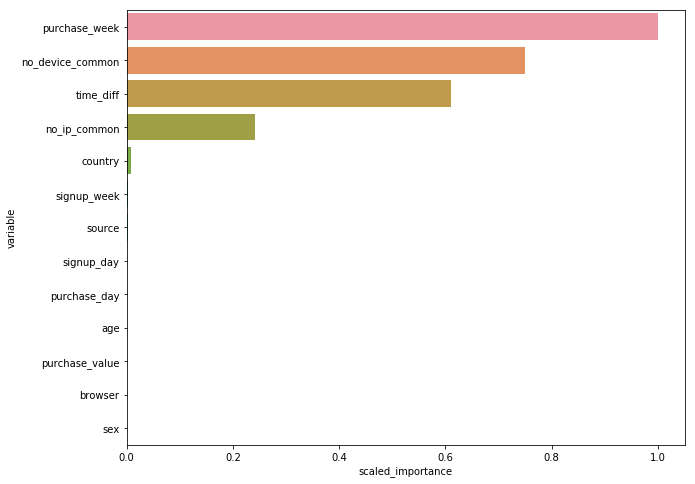

In [404]:
# Feature importance
importance = model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.show()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


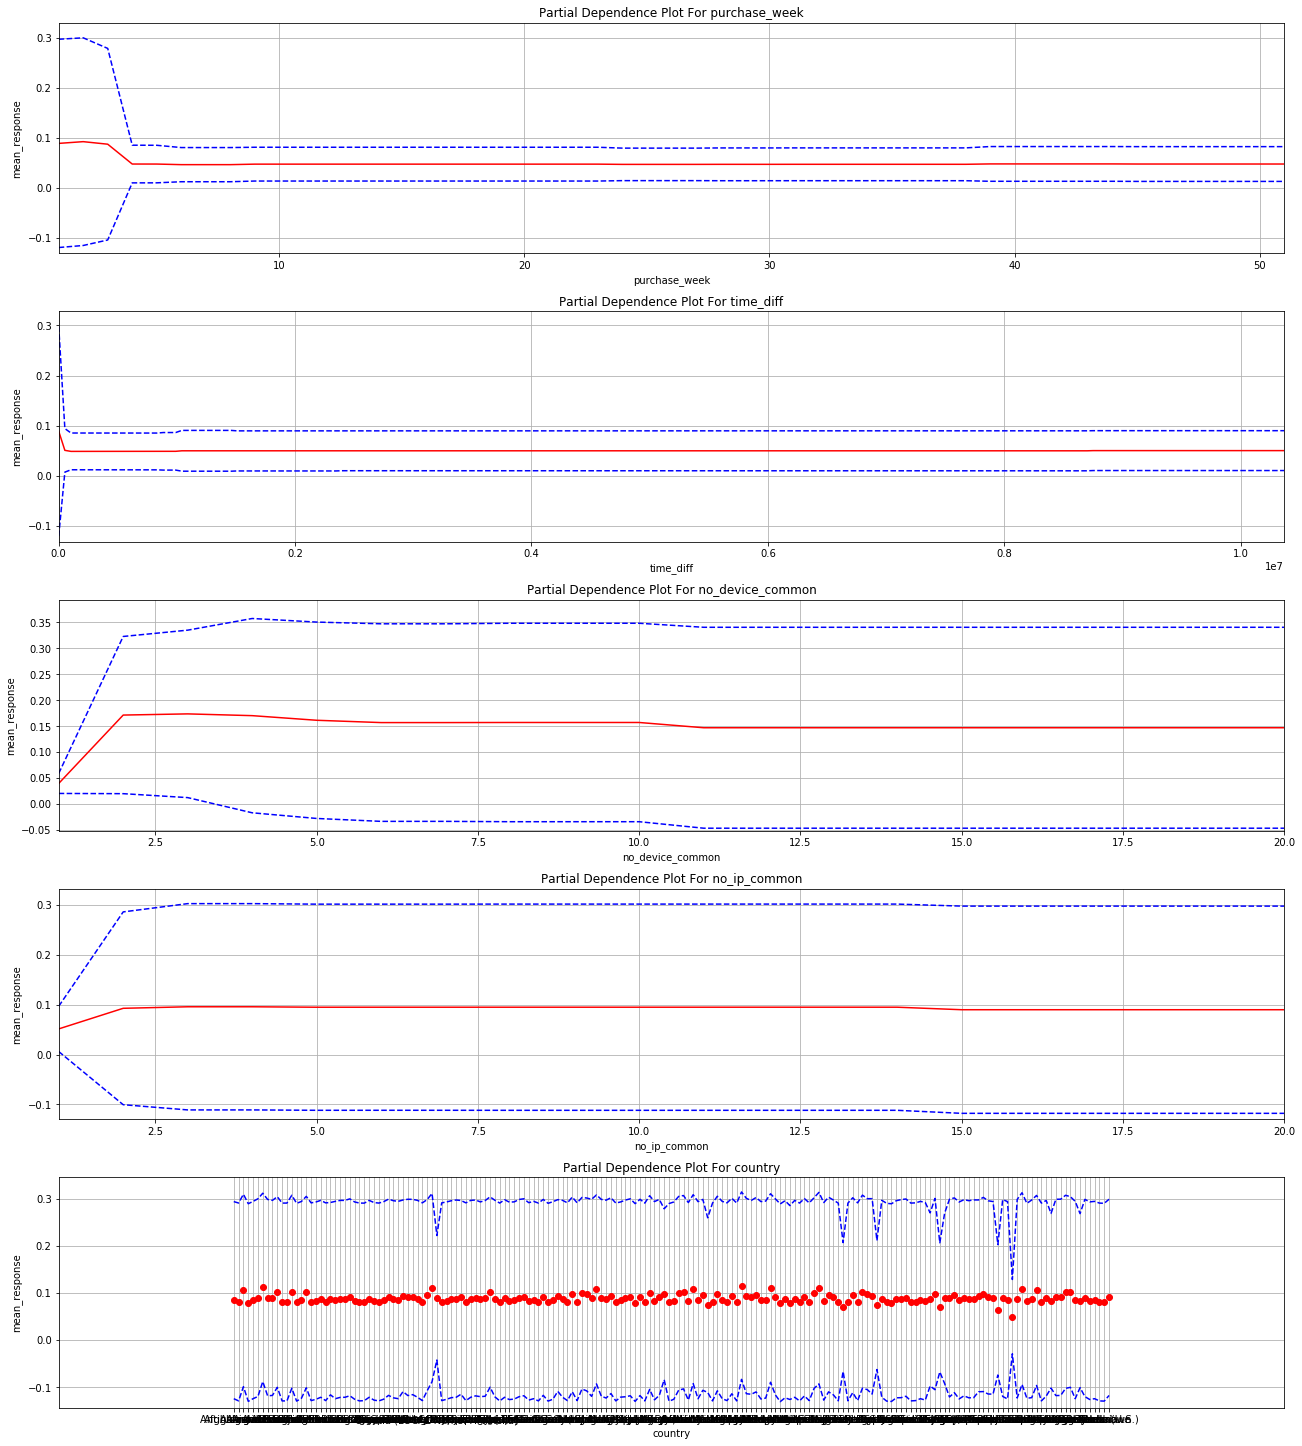

In [409]:
cols = ['purchase_week', 'time_diff', 'no_device_common', 'no_ip_common', 'country']
_ = model.partial_plot(data=train, cols=cols, nbins=200, figsize=(18, 20))

https://www.kaggle.com/dansbecker/partial-dependence-plots

Based on the analysis below, among all the countries, countries Turkmenistan, Namibia, Sri Lanka, Luxembourg, Virgin Islands (U.S.), Ecuador, Tunisia, Peru, Bolivia, Kuwait are the top 10 high risk countries.

In [419]:
# Shutdown h2o instance
h2o.cluster().shutdown()

H2O session _sid_b926 closed.


In [418]:
df = fraud_df
variable = 'country'
target= 'class' 
ncat=1000

# cut bkt by percentile, ncat is the number of levels for a variable to be considered as continuous variable

if df[variable].nunique()>= ncat:            
    cut = pd.cut(df[variable], np.percentile(df[variable], [0, 20, 40, 60, 80, 100]), include_lowest = True)
    new_name = variable+'_bkt'
    cut.name = new_name
    bkt = pd.concat([df,cut],axis=1)
else:
    new_name = variable+'_bkt'
    bkt = df.rename(columns={variable:new_name})
# calculate the Odds Ratio
lst = []
for i in range(bkt[new_name].nunique()):
    val = list(bkt[new_name].unique())[i]
    lst.append([variable, val, bkt[bkt[new_name] == val].count()[new_name], bkt[(bkt[new_name] == val) & (bkt[target] == 1)].count()[new_name]])

data = pd.DataFrame(lst, columns = ['Variable', 'Value', 'All', 'Bad'])
data = data[data['Bad'] > 0]
data['odds_ratio'] = np.log(data['Bad']/(data['All'] - data['Bad']))
    
data['Value'] = data['Value'].apply(lambda x: str(x))
data = data.sort_values(by= 'odds_ratio', ascending = False)
    
data.head(10).Value

92              Turkmenistan
81                   Namibia
119                Sri Lanka
114               Luxembourg
127    Virgin Islands (U.S.)
50                   Ecuador
74                   Tunisia
14                      Peru
62                   Bolivia
96                    Kuwait
Name: Value, dtype: object

# Model Usage and Recommendation
<a id="re"></a> 
From a product perspective, how would you use the model to tell if an activity is fraudulent or not? That is, what kind of different user experiences would you build based on the model output?

The model is able to predict probability of fradulent users, and the company can set cut-offs to customize different user experience based on the predict probability of fradulence. e.g.
* p <0.6: non-fraudulent users, normal transaction experience
* 0.6<=p<0.8: fraudulent risky users. The website needs to ask for further identification verification and payment verification information
* p >= 0.8: high fraudulent risk users. The website needs to block transaction activities from those users.